### <font color='blue'>**Data Exploration + XGBoost starter model**
    Pulled from Eric's notebook


In [1]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
class Dataset:
    def __init__(self, pep_df, min_timepoints_per_patient=2):
        '''
        pep_df should be the pep_reduced_intensity_df we created above
        This dataset will only include patients with at least `min_timepoints_per_patient` timepoints
        '''
        self.pep_df = pep_df
        
        self.data = {} # patient id -> [array of timepoint vectors]
        for patient_idx in range(1, 58+1):
            patient_timepoint_vectors = []
            for timepoint in range(1, 7+1):
                try:
                    # We replace all nans with zeros using np.nan_to_num
                    patient_timepoint_vector = np.nan_to_num(self.pep_df[f"Patient_{patient_idx:02d}.Timepoint_{timepoint:01d}"].values)
                    patient_timepoint_vectors.append(patient_timepoint_vector)
                except:
                    # This patient timepoint doesnt exist in the data
                    pass
            
            # If this patient had at least `min_timepoints_per_patient` timepoints, then include this patient id
            if len(patient_timepoint_vectors) >= min_timepoints_per_patient:
                self.data[patient_idx] = patient_timepoint_vectors
                
    @staticmethod
    def prepare_df(filepath):
        df = pd.read_csv(filepath, sep="\t")
        
        # only keep the Patient_x.Timepoint_y formatted columns
        df = df.iloc[:, :667]
        
        # Remove all _unmod columns
        df = df[df.columns.drop(list(df.filter(regex='.\_unmod')))]
        
        # Convert the string abundance numbers into ints for all patient timepoint cols
        def convert_to_number(val):
            if isinstance(val, str):
                return int(val.replace(",","").strip())
            return val

        for patient_timepoint_col in df.columns.values[32:]:
            df[patient_timepoint_col] = df[patient_timepoint_col].apply(convert_to_number)
            df[patient_timepoint_col] = df[patient_timepoint_col].astype(float)
        
        return df
    
    @classmethod
    def from_file(cls, filepath, *args, **kwargs):
        pip_df = cls.prepare_df(filepath)
        return cls(pip_df, *args, **kwargs)
        
                
    def data_generator(self, patient_ids, num_samples, peptide_indices=None, same_patient_pair_probability=0.5):
        """
        This will return a generator that will yield `num_samples` sample pairs of peptide vectors 
        (limited to only the `patient_ids` given, and the `peptide_indices` given (if none is given, then all peptides will be included))
        such that, `same_patient_pair_probability` of the time, the pair of vectors will be from the same patient (but different time points)
        
        Note: when same_patient_pair_probability is None, it will model the true data distribution by putting all timepoint vectors into 1 bucket
        and randomly sampling from this (this will make it such that it is always way more likely for the timepoint vectors to be from different patients than the same one)
        
        Data samples yielded by the returned generator will be of the form:
        {
            "first_patient_idx" : ...,
            "first_patient_timepoint_vector" : ...,
            "second_patient_idx" : ...,
            "second_patient_timepoint_vector" : ...,
            "is_same_patient" : True/False
        }
        
        """
        # First ensure all of the given patient ids are in out prepared dataset
        assert all(pid in self.data for pid in patient_ids), "Not all of the given patient ids are in our dataset"
        
        
        def true_data_dist_gen():
            # This generator is used when same_patient_pair_probability is None
            all_patient_timepoint_vectors = []
            for patient_idx in patient_ids:
                for patient_timepoint_vector in self.data[patient_idx]:
                    all_patient_timepoint_vectors.append((patient_idx, patient_timepoint_vector))
            
            for _ in range(num_samples):
                first_patient_id, first_patient_timepoint_vector = random.choice(all_patient_timepoint_vectors)
                second_patient_id, second_patient_timepoint_vector = random.choice(all_patient_timepoint_vectors)
                
                # if peptide_indices is given, filter the vectors to only include the `peptide_indices` peptides
                if peptide_indices:
                    first_patient_timepoint_vector = first_patient_timepoint_vector[peptide_indices]
                    second_patient_timepoint_vector = second_patient_timepoint_vector[peptide_indices]
                    
                yield {
                    "first_patient_id" : first_patient_id,
                    "first_patient_timepoint_vector" : first_patient_timepoint_vector,
                    "second_patient_id" : second_patient_id,
                    "second_patient_timepoint_vector" : second_patient_timepoint_vector,
                    "is_same_patient" : first_patient_id == second_patient_id
                }

        
        def data_gen():
            # This generator is used when same_patient_pair_probability is NOT None
            for _ in range(num_samples):
                
                # pick a random first patient id
                first_patient_id = random.choice(patient_ids)
                
                # pick a random timepoint vector for this first patient id
                first_patient_timepoint_vector = random.choice(self.data[first_patient_id])
                
                # decide if the second patient in our pair should be the same as the first
                is_second_patient_same = random.random() <= same_patient_pair_probability
                
                if is_second_patient_same:
                    second_patient_id = first_patient_id
                else:
                    second_patient_id = random.choice([pid for pid in patient_ids if pid != first_patient_id])
                
                # Note: In this approach, it is possible that, when the second patient = first patient,
                # They both return the same timepoint vector. but that should be okay, since this will help the model learn
                # to detect identical inputs, especially when the input to the model is the concatenated vector
                second_patient_timepoint_vector = random.choice(self.data[second_patient_id])
                
                # if peptide_indices is given, filter the vectors to only include the `peptide_indices` peptides
                if peptide_indices:
                    first_patient_timepoint_vector = first_patient_timepoint_vector[peptide_indices]
                    second_patient_timepoint_vector = second_patient_timepoint_vector[peptide_indices]
                
                yield {
                    "first_patient_id" : first_patient_id,
                    "first_patient_timepoint_vector" : first_patient_timepoint_vector,
                    "second_patient_id" : second_patient_id,
                    "second_patient_timepoint_vector" : second_patient_timepoint_vector,
                    "is_same_patient" : first_patient_id == second_patient_id
                }

        # Based on same_patient_pair_probability, return the correct data generator
        if same_patient_pair_probability is None:
            return true_data_dist_gen()
        else:
            return data_gen()

In [3]:
DATA_DIR = "./Data"
DATA_TSV_FILEPATH = os.path.join(DATA_DIR, "peptidoforms_intensity", "data.tsv")

In [4]:
# Establish all random seeds
random.seed(2021)

# TODO: other libraries should be seeded here, like sklearn, torch, xgboost, etc.

### <font color='blue'>**Creating Main Dataset**

In [5]:
peptidoforms_intensity_dataset = Dataset.from_file(DATA_TSV_FILEPATH)

/Users/subby/UCSD/CSE_291C/Projects/cse291c-plasma-weightloss/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (38,42,44,48,52,56,92,98,102,108,116,122,124,126,128,130,132,134,138,140,144,146,148,150,152,154,156,176,184,190,196,200,212,216,228,234,236,238,242,244,246,248,250,252,254,256,258,260,262,264,268,270,272,274,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,322,324,330,332,334,336,338,340,342,344,346,350,364,372,374,378,380,382,388,390,392,394,398,404,406,408,410,412,414,416,426,428,440,444,446,454,458,460,464,466,468,484,502,510,514,516,522,524,526,528,538,540,542,544,552,554,556,558,562,576,592,606,608,610,612,618,622,624,626,628,630,632,640,642,644,646,650,652,654,656,658,660,662,664,674,676,678,684,686,692,694,696,698,700,702) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
peptidoforms_intensity_df = peptidoforms_intensity_dataset.pep_df
peptidoforms_intensity_df.shape

(40921, 350)

In [7]:
# For each peptide index, count the number of NON-NaNs it has across all patient timepoints
peptide_nonempty_count_across_patient_timepoints = np.count_nonzero(~np.isnan(peptidoforms_intensity_df.values[:,32:].astype(float)), axis=-1)
peptide_nonempty_count_across_patient_timepoints

array([318, 318, 318, ...,   1,   7,   1])

In [8]:
pd.Series(peptide_nonempty_count_across_patient_timepoints).describe()

count    40921.000000
mean        25.752572
std         68.130665
min          0.000000
25%          0.000000
50%          0.000000
75%          8.000000
max        318.000000
dtype: float64

In [9]:
len(peptide_nonempty_count_across_patient_timepoints[peptide_nonempty_count_across_patient_timepoints <= 100])

37461

---

### <font color='blue'>**Creating Train/Val/Test Datasets**
    
Train and val datasets will enforce the `same_patient_pair_probability = 0.5`, while the test set will use the true data distribution

In [10]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [11]:
# For now, we don't select a particular subset of peptides, and just use all of them.
selected_peptide_indices = None

In [12]:
train_same_patient_pair_probability = 0.5
val_same_patient_pair_probability = 0.5
test_same_patient_pair_probability = None

In [13]:
# using 1k samples for train/val/test finishes fast, but may not be accurate
# so we should train with more samples (~100K train/val/test) with colab/gpu later, which would take more time
num_train_samples = 10000
num_val_samples = 10000
num_test_samples = 10000

In [14]:
all_patient_ids = list(peptidoforms_intensity_dataset.data.keys())
num_patient_ids = len(all_patient_ids)
num_patient_ids

52

In [15]:
random.shuffle(all_patient_ids)
train_patient_ids, val_patient_ids, test_patient_ids = np.split(all_patient_ids, 
                                                                [int(train_ratio * num_patient_ids), 
                                                                 int((train_ratio + val_ratio) * num_patient_ids)
                                                                ])
train_patient_ids = train_patient_ids.tolist()
val_patient_ids = val_patient_ids.tolist()
test_patient_ids = test_patient_ids.tolist()

len(train_patient_ids), len(val_patient_ids), len(test_patient_ids)

(31, 10, 11)

In [16]:
def create_data_arrays_from_generator(gen):
    """
    The input is a concatenated vector of the 2 patient vectors, and the output is 1/0 if the vectors are from the same patient or not
    """
    X, Y = [], []
    
    for data_input in tqdm(gen):
        x = np.hstack((data_input['first_patient_timepoint_vector'], data_input['second_patient_timepoint_vector'])).astype(int)
        y = 1 if data_input['is_same_patient'] else 0
        
        X.append(x)
        Y.append(y)

    return X, Y

In [17]:
train_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=train_patient_ids, 
    num_samples=num_train_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=train_same_patient_pair_probability)
trainX, trainY = create_data_arrays_from_generator(train_data_gen)

val_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=val_patient_ids, 
    num_samples=num_val_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=val_same_patient_pair_probability)
valX, valY = create_data_arrays_from_generator(val_data_gen)

test_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=test_patient_ids, 
    num_samples=num_test_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=test_same_patient_pair_probability)
testX, testY = create_data_arrays_from_generator(test_data_gen)

10000it [00:04, 2332.82it/s]
10000it [00:05, 1692.23it/s]
10000it [00:06, 1506.25it/s]


---

## NOTE on using scalers: 
Current approach of just using standard scaling on concatenated input feature vectors is likely not optimal/correct.

This is because, the first half and the second half of each concatenated feature vector is semantically the same, yet the scaler will scale them differently.

A better approach may be to create a data matrix of shape (num peptide, num patient time points) (and replacing all NaNs with 0s), and fit the standard scaler on this (using only the training patient ids). Then, when transforming the data, we transform the first half of each vector and the second half of each vector separately (using the same scaler), and concat these 2 scaled halfs to create a new scaled & concatenated feature vector

However, tree-based methods (including XGBoost) are invariant to feature scaling, so they don't need any scaling: https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalise-data-for-xgboost

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# helper method to print basic model metrics
def metrics(y_true, y_pred):
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
    print('\nReport:\n', classification_report(y_true, y_pred))

### <font color='blue'>**XGBoost Classifier**
Initial log loss should be around $0.69$, since $-ln(0.5) = 0.6931471806$ and there is a $0.5$ probability of same/different patient

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Apply transform to both the training set and the test set.
train_dataX = np.array(trainX) # scaler.transform(trainX)
val_dataX = np.array(valX) # scaler.transform(valX)
test_dataX = np.array(testX) # scaler.transform(testX)

train_dataY = np.array(trainY)
val_dataY = np.array(valY)
test_dataY = np.array(testY)

In [27]:
pd.Series(train_dataY).value_counts()

0    5005
1    4995
dtype: int64

In [28]:
pd.Series(val_dataY).value_counts()

1    5079
0    4921
dtype: int64

In [29]:
pd.Series(test_dataY).value_counts()

0    8954
1    1046
dtype: int64

In [20]:
model = XGBClassifier(use_label_encoder=False, max_depth=3)
model.fit(train_dataX, train_dataY, eval_metric="logloss", eval_set=[(val_dataX, val_dataY)], verbose=True)

[0]	validation_0-logloss:0.68995
[1]	validation_0-logloss:0.67595
[2]	validation_0-logloss:0.67716
[3]	validation_0-logloss:0.66137
[4]	validation_0-logloss:0.64409
[5]	validation_0-logloss:0.64687
[6]	validation_0-logloss:0.64744
[7]	validation_0-logloss:0.64738
[8]	validation_0-logloss:0.64494
[9]	validation_0-logloss:0.59304
[10]	validation_0-logloss:0.59140
[11]	validation_0-logloss:0.57336
[12]	validation_0-logloss:0.56571
[13]	validation_0-logloss:0.56120
[14]	validation_0-logloss:0.56080
[15]	validation_0-logloss:0.54087
[16]	validation_0-logloss:0.52551
[17]	validation_0-logloss:0.50876
[18]	validation_0-logloss:0.50779
[19]	validation_0-logloss:0.48774
[20]	validation_0-logloss:0.48405
[21]	validation_0-logloss:0.48512
[22]	validation_0-logloss:0.48524
[23]	validation_0-logloss:0.47938
[24]	validation_0-logloss:0.48048
[25]	validation_0-logloss:0.48005
[26]	validation_0-logloss:0.48052
[27]	validation_0-logloss:0.46323
[28]	validation_0-logloss:0.46518
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
# Train metrics
train_ypred = model.predict(train_dataX)
train_predictions = [round(value) for value in train_ypred]

metrics(train_dataY, train_predictions)
train_accuracy = accuracy_score(train_dataY, train_predictions)

print("Train accuracy - ", train_accuracy)

Confusion matrix:
 [[5005    0]
 [   0 4995]]

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00      4995

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Train accuracy -  1.0


In [22]:
# Validation metrics
val_ypred = model.predict(val_dataX)
val_predictions = [round(value) for value in val_ypred]

metrics(val_dataY, val_predictions)
val_accuracy = accuracy_score(val_dataY, val_predictions)

print("Val accuracy - ", val_accuracy)

Confusion matrix:
 [[4904   17]
 [ 525 4554]]

Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      4921
           1       1.00      0.90      0.94      5079

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Val accuracy -  0.9458


In [23]:
# Test metrics
test_ypred = model.predict(test_dataX)
test_predictions = [round(value) for value in test_ypred]

metrics(test_dataY, test_predictions)
test_accuracy = accuracy_score(test_dataY, test_predictions)

print("Test accuracy - ", test_accuracy)

Confusion matrix:
 [[8952    2]
 [  91  955]]

Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8954
           1       1.00      0.91      0.95      1046

    accuracy                           0.99     10000
   macro avg       0.99      0.96      0.97     10000
weighted avg       0.99      0.99      0.99     10000

Test accuracy -  0.9907


In [153]:
## Save model
model.save_model('xgboost_model_all_peptides_10Ksamples_train_val_test.json')

### <font color='blue'>**Important peptides analysis**

In [69]:
ft = model.feature_importances_
np.save("model_feature_importances.npy", ft)

In [70]:
len(ft[ft > 0]) # count number of peptides with a non-zero weight

540

In [42]:
num_unique_peptides = len(peptidoforms_intensity_df)
assert num_unique_peptides * 2 == len(ft)

In [61]:
ft[ft > 0].sum() # all non-zero feature weights should sum to 1.0

1.0

<AxesSubplot:>

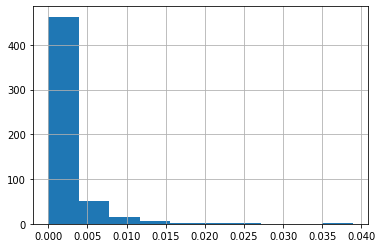

In [71]:
# x-axis is weight and y-axis is count
# this shows that very, very few peptides have a significant weight (ie., > 0.035)
pd.Series(ft[ft > 0]).hist()

In [137]:
nonzeroweight_peptide_indices = np.argwhere(ft > 0).flatten()

# Count number of peptide indices that were important from the FIRST patient (ie., first half of the input feature vec)
(nonzeroweight_peptide_indices < num_unique_peptides).sum()

270

In [138]:
# Count number of peptide indices that were important from the SECOND patient (ie., second half of the input feature vec)
(nonzeroweight_peptide_indices >= num_unique_peptides).sum()

270

In [142]:
# All peptide indices that were important from the FIRST input patient
important_peptide_indices_for_first_patient = nonzeroweight_peptide_indices[nonzeroweight_peptide_indices < num_unique_peptides]
important_peptide_indices_for_first_patient

array([    0,     3,     4,    10,    12,    15,    18,    57,    58,
         113,   126,   143,   184,   206,   276,   301,   340,   373,
         400,   406,   496,   499,   588,   599,   603,   607,   608,
         614,   634,   667,   687,   696,   699,   713,   757,   779,
         820,   896,   913,   956,   978,   983,   991,  1054,  1068,
        1071,  1098,  1119,  1171,  1193,  1194,  1203,  1220,  1232,
        1351,  1398,  1471,  1546,  1633,  1664,  1722,  1729,  1757,
        1783,  1805,  1809,  1817,  1822,  1837,  1865,  1913,  1948,
        1966,  1969,  1970,  2093,  2097,  2108,  2139,  2157,  2161,
        2198,  2230,  2242,  2295,  2302,  2313,  2317,  2323,  2354,
        2357,  2361,  2401,  2482,  2493,  2534,  2583,  2598,  2649,
        2701,  2730,  2760,  2849,  2890,  2903,  2945,  2969,  2977,
        2981,  2998,  3026,  3035,  3040,  3069,  3158,  3162,  3271,
        3304,  3394,  3410,  3418,  3426,  3557,  3572,  3585,  3615,
        3717,  3726,

In [143]:
# All peptide indices that were important from the SECOND input patient
important_peptide_indices_for_second_patient = nonzeroweight_peptide_indices[nonzeroweight_peptide_indices >= num_unique_peptides] % num_unique_peptides
important_peptide_indices_for_second_patient

array([    0,     5,     6,    14,    23,    27,    42,    50,   105,
         118,   121,   131,   143,   144,   183,   259,   276,   306,
         332,   333,   334,   340,   373,   390,   406,   444,   450,
         494,   503,   536,   608,   614,   621,   634,   647,   667,
         669,   707,   757,   758,   817,   823,   830,   885,   932,
         956,   991,  1028,  1033,  1054,  1101,  1132,  1173,  1193,
        1217,  1232,  1263,  1288,  1321,  1343,  1363,  1383,  1384,
        1412,  1449,  1462,  1503,  1546,  1547,  1633,  1675,  1710,
        1757,  1805,  1809,  1811,  1856,  1892,  1906,  1929,  1966,
        1969,  1970,  2005,  2097,  2101,  2108,  2123,  2230,  2242,
        2248,  2295,  2302,  2323,  2357,  2361,  2453,  2493,  2502,
        2515,  2519,  2575,  2583,  2657,  2689,  2698,  2717,  2739,
        2804,  2838,  2849,  2903,  2934,  2945,  2969,  3026,  3035,
        3040,  3089,  3145,  3158,  3194,  3205,  3336,  3394,  3402,
        3418,  3489,

In [147]:
# Because the first half of the features and the second half are semantically the same, 
# we have to % by the number of unique peptides (ie., the size of the first half of each combined feature vector)
# to get the unique set of peptides that are deemed important
important_peptide_indices = np.unique(np.where(ft > 0)[0] % num_unique_peptides)
len(important_peptide_indices)

435

In [148]:
# In this case, 105 of the 435 important peptides (ie., peptides with non-zero weight) are important to consider for both patients
# the rest of the 330 important peptides are each only important to either the first patient or the second patient
peptide_indices_that_are_important_for_both_patients = set(important_peptide_indices_for_first_patient.tolist()) & set(important_peptide_indices_for_second_patient.tolist())
len(peptide_indices_that_are_important_for_both_patients)

105

In [105]:
def get_patients_peptide_is_present_in(peptide_index):
    present_patient_timepoints = peptidoforms_intensity_df.iloc[peptide_index, 32:].dropna().index
    
    patients = set()
    for pt in present_patient_timepoints:
        spltidx = pt.index(".Timepoint_")
        patient_id = int(pt[:spltidx].replace("Patient_", ""))
        patients.add(patient_id)
    
    return patients

In [122]:
# lets get some of the most important peptides
np.argwhere(ft >= 0.020).flatten() % num_unique_peptides

array([ 1970,  4298,  4014, 16763])

In [121]:
# Getting the number of patients that some of the most important peptides are found in
len(get_patients_peptide_is_present_in(1970)), len(get_patients_peptide_is_present_in(4298)), len(get_patients_peptide_is_present_in(4014)), len(get_patients_peptide_is_present_in(16763))

(32, 7, 24, 15)

In [149]:
original_data_df = pd.read_csv(DATA_TSV_FILEPATH, sep="\t")
assert original_data_df.shape[0] == peptidoforms_intensity_df.shape[0]

/Users/subby/UCSD/CSE_291C/Projects/cse291c-plasma-weightloss/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (38,42,44,48,52,56,92,98,102,108,116,122,124,126,128,130,132,134,138,140,144,146,148,150,152,154,156,176,184,190,196,200,212,216,228,234,236,238,242,244,246,248,250,252,254,256,258,260,262,264,268,270,272,274,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,322,324,330,332,334,336,338,340,342,344,346,350,364,372,374,378,380,382,388,390,392,394,398,404,406,408,410,412,414,416,426,428,440,444,446,454,458,460,464,466,468,484,502,510,514,516,522,524,526,528,538,540,542,544,552,554,556,558,562,576,592,606,608,610,612,618,622,624,626,628,630,632,640,642,644,646,650,652,654,656,658,660,662,664,674,676,678,684,686,692,694,696,698,700,702) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [150]:
original_data_df = original_data_df.iloc[important_peptide_indices]

In [151]:
original_data_df.to_csv("important_peptidoforms_selected_by_xgboost_all_columns.csv", index=None)

In [152]:
peptidoforms_intensity_df.iloc[important_peptide_indices].to_csv("important_peptidoforms_selected_by_xgboost.csv", index=None)